In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.pyplot import figure
from statsmodels.stats.outliers_influence import OLSInfluence
from sklearn import linear_model
import seaborn as sns

In [2]:
Risk_Factors_df = pd.read_excel('Risk_Factors.xlsx')
market_df = pd.read_excel('Market_Portfolio.xlsx')
industry_df = pd.read_excel('Industry_Portfolios.xlsx')

/Users/User2/opt/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:300: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [3]:
industry_df2 = industry_df.iloc[:,1:].copy()
industry_minus_rf_df = industry_df2.sub(Risk_Factors_df['Rf'],axis=0)

In [12]:
my_columns = ['Industry','Intercept','Slope']
params_table = pd.DataFrame(columns = my_columns)

def Ols_result(dependent_df,independent_df,params_table):
    for x in dependent_df.columns:
        dep_var = dependent_df[x]
        indep_var = independent_df
        indep_var_const = sm.add_constant(independent_df)
        
        model = sm.OLS(dep_var,indep_var_const)
        result = model.fit()
        
        a,b = result.params
        params_table = params_table.append(pd.Series([x,a,b],index=my_columns),ignore_index=True)
        
        #print(result.summary())
        #display(result.params)
        
        #my_plot = plt.figure()
        #my_plot = plt.plot(indep_var,dep_var,'ro')
        #my_plot = plt.plot(indep_var,result.fittedvalues, label = f'{x}')
        #plt.legend()
        
    return (params_table)

In [13]:
params_table1 = Ols_result(industry_minus_rf_df,Risk_Factors_df['Rm-Rf'],params_table)

/Users/User2/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [15]:
params_table1

,Industry,Intercept,Slope
0,NoDur,0.369717,0.653744
1,Durbl,-0.417903,1.649374
2,Manuf,0.160494,1.167929
3,Enrgy,0.504485,0.965527
4,HiTec,-0.064024,1.132387
5,Telcm,0.194348,0.901721
6,Shops,0.274093,0.829515
7,Hlth,0.236968,0.675890
8,Utils,0.446523,0.537009
9,Other,-0.387508,1.206992


In [23]:
Treynor_Ratio = industry_minus_rf_df.mean()/(params_table1['Slope'].values)
Treynor_Ratio

NoDur    1.186372
Durbl    0.367463
Manuf    0.758251
Enrgy    1.143330
HiTec    0.564295
Telcm    0.836363
Shops    0.951258
Hlth     0.971435
Utils    1.452334
Other    0.299781
dtype: float64

In [24]:
sharpe_ratio = industry_minus_rf_df.mean()/np.std(industry_minus_rf_df)
sharpe_ratio

NoDur    0.232068
Durbl    0.072659
Manuf    0.167315
Enrgy    0.182470
HiTec    0.119050
Telcm    0.169773
Shops    0.192557
Hlth     0.173253
Utils    0.211832
Other    0.064964
dtype: float64

In [18]:
target = Risk_Factors_df['Rf']
sortino_temp1 = industry_df2.sub(target,axis=0)
sortino_temp2 = sortino_temp1.applymap(lambda x: x if x<0 else 0)
sortino_temp3 = (sortino_temp2**2).mean()

In [25]:
Sortino_ratio = sortino_temp1.mean()/np.sqrt(sortino_temp3)
Sortino_ratio

NoDur    0.350804
Durbl    0.111967
Manuf    0.241260
Enrgy    0.273612
HiTec    0.170620
Telcm    0.244940
Shops    0.293032
Hlth     0.270294
Utils    0.290044
Other    0.087351
dtype: float64

In [26]:
Jensen_Alpha = industry_minus_rf_df.mean()-(params_table1['Slope']*Risk_Factors_df['Rm-Rf'].mean()).values
Jensen_Alpha

NoDur    0.369717
Durbl   -0.417903
Manuf    0.160494
Enrgy    0.504485
HiTec   -0.064024
Telcm    0.194348
Shops    0.274093
Hlth     0.236968
Utils    0.446523
Other   -0.387508
dtype: float64

In [38]:
my_columns = ['Y_Intercept','market_risk_slope','size_risk_slope','value_risk_slope']
params_table = pd.DataFrame(columns = my_columns)

def Fama_multiple_regression(independent_df,independent_list,dependent_df,dependent_list,params_table):
    for x in dependent_list:
        model = linear_model.LinearRegression()
        model.fit(independent_df[independent_list],dependent_df[x])
        a,b,c = model.coef_
        y = model.intercept_
        params_table = params_table.append(pd.Series((y,a,b,c),index=my_columns),ignore_index=True)
    params_table.index = dependent_list
    return params_table

In [41]:
Fama_params_table2 = Fama_multiple_regression(Risk_Factors_df,['Rm-Rf','SMB','HML'],industry_minus_rf_df,industry_df2.columns,params_table)

Fama_params_table2

,Y_Intercept,market_risk_slope,size_risk_slope,value_risk_slope
NoDur,0.386704,0.712134,-0.229102,-0.023342
Durbl,-0.474342,1.447452,0.670878,0.240949
Manuf,0.153285,1.142282,0.087388,0.027727
Enrgy,0.523007,1.028354,-0.259360,-0.008158
HiTec,-0.065979,1.152803,0.335674,-0.556947
Telcm,0.200724,0.924137,-0.080299,-0.019063
Shops,0.255941,0.770227,0.280191,-0.039080
Hlth,0.257472,0.751976,-0.212655,-0.143765
Utils,0.474411,0.631827,-0.387961,-0.016881
Other,-0.404412,1.123473,-0.061676,0.547325


In [42]:
performance_metrics_df = pd.DataFrame({'Sharpe_Ratio':sharpe_ratio,
                                       'Sortino_Ratio':Sortino_ratio,
                                       'Treynor_Ratio':Treynor_Ratio,
                                       "Jensen's_\u03B1":Jensen_Alpha,
                                       'Three-factor_α': Fama_params_table2['Y_Intercept']
                                      })

In [58]:
performance_metrics_df 

,Sharpe_Ratio,Sortino_Ratio,Treynor_Ratio,Jensen's_α,Three-factor_α
NoDur,0.232068,0.350804,1.186372,0.369717,0.386704
Durbl,0.072659,0.111967,0.367463,-0.417903,-0.474342
Manuf,0.167315,0.241260,0.758251,0.160494,0.153285
Enrgy,0.182470,0.273612,1.143330,0.504485,0.523007
HiTec,0.119050,0.170620,0.564295,-0.064024,-0.065979
Telcm,0.169773,0.244940,0.836363,0.194348,0.200724
Shops,0.192557,0.293032,0.951258,0.274093,0.255941
Hlth,0.173253,0.270294,0.971435,0.236968,0.257472
Utils,0.211832,0.290044,1.452334,0.446523,0.474411
Other,0.064964,0.087351,0.299781,-0.387508,-0.404412


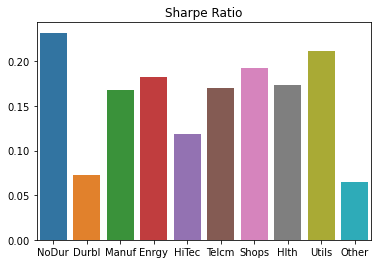

In [57]:
sns.barplot(x = performance_metrics_df.index,y = 'Sharpe_Ratio', data = performance_metrics_df)
plt.title('Sharpe Ratio')
plt.ylabel('')
plt.show()

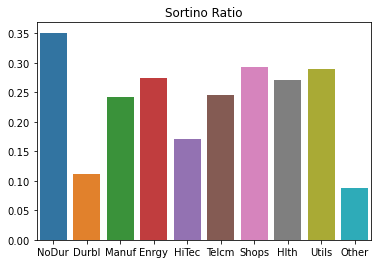

In [56]:
sns.barplot(x = performance_metrics_df.index,y = 'Sortino_Ratio', data = performance_metrics_df)
plt.title('Sortino Ratio')
plt.ylabel('')
plt.show()

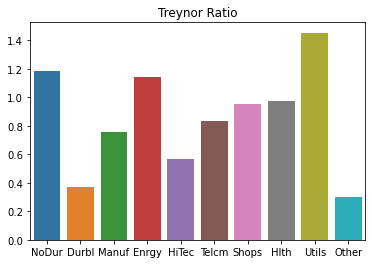

In [55]:
sns.barplot(x = performance_metrics_df.index,y = 'Treynor_Ratio', data = performance_metrics_df)
plt.title('Treynor Ratio')
plt.ylabel('')
plt.show()

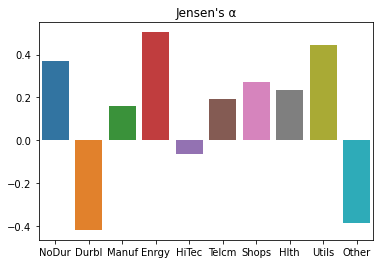

In [54]:
sns.barplot(x = performance_metrics_df.index,y = "Jensen's_\u03B1", data = performance_metrics_df)
plt.title("Jensen's \u03B1")
plt.ylabel('')
plt.show()

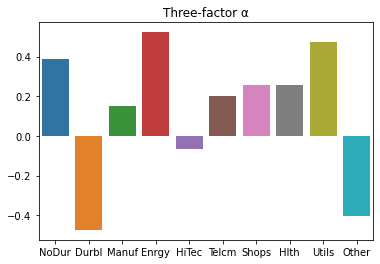

In [53]:
sns.barplot(x = performance_metrics_df.index,y = "Three-factor_α", data = performance_metrics_df)
plt.title("Three-factor α")
plt.ylabel('')
plt.show()